Classify handwritten digits with k-NN
---

Solution - Load dataset
--

> **Exercise**: Load the data from the `c4_mnist-6k.npz` file into X/y arrays. The data type of the input matrix `X` should be `float64`. Split it into train (5,000 images) and test (1,000) sets using the `train_test_split()` function. Set the `random_state` to zero. 

In [11]:
# Load data and extract the keys that are found in the main file
import numpy as np
import os

# Load the numpy .npz file
with np.load("c4_mnist-6k.npz", allow_pickle=False) as data:
    mnist_data = dict(data.items())

print("Data loaded")
print("It is a dictionary with keys:", list(mnist_data.keys()))

Data loaded
It is a dictionary with keys: ['data', 'labels']


In [12]:
# Create X/y arrays with the keys
# X: Input que contiene las imagenes como columnas
# y: Labels que dicen qué numero es cada imagen
X = mnist_data["data"]
y = mnist_data["labels"]

# See how many features can be found in the Data set (in this case 784)
print("X:", X.shape, X.dtype)
print("y:", y.shape, y.dtype)

# Dont forget that in this case data are the number pictures that are 
# encripted in single columns



X: (6000, 784) uint8
y: (6000,) int32


In [13]:
from sklearn.model_selection import train_test_split

# Convert the type of the input matrix to float
X = X.astype(np.float)

# Split data into train/test sets
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, train_size=5000, test_size=1000, random_state=0
)

Solution: Data exploration
---

> **Exercise**: What are the different categories? What is the proportion of images in each one?

In [14]:
import pandas as pd

# The categories correspond to digits from 0 and 9
# There is approximately the same proportion of images (~10%) for each class
pd.value_counts(y, normalize=True)

1    0.111833
7    0.108500
4    0.103833
3    0.101333
6    0.101333
9    0.100167
0    0.098667
2    0.096833
8    0.091833
5    0.085667
dtype: float64

> **Exercise**: Plot some images with their labels from the X/y arrays.

Label: 1


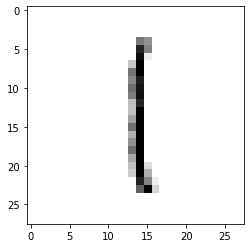

Label: 3


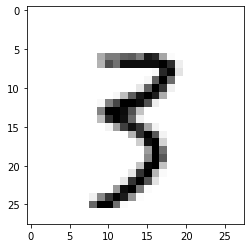

Label: 8


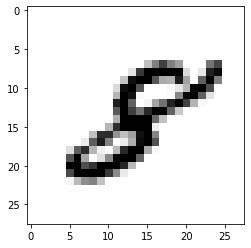

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

# Function to plot the i-th image from some X/y arrays
def show_image(idx, X, y):
    # Get image pixels from the input matrix X
    flat_img = X[idx]  # has shape (784,)

    # Reshape image into a 28x28 array
    img = flat_img.reshape(28, 28)

    # Print label using the output vector y
    print("Label:", y[idx])

    # Plot image with pyplot
    plt.imshow(img, cmap=plt.cm.gray_r)
    plt.show()


# Show the first images from the training set
show_image(0, X_tr, y_tr)
show_image(1, X_tr, y_tr)
show_image(2, X_tr, y_tr)

Solution: Set a baseline
---

> **Exercise**: Create a baseline model using the `DummyClassifier` object from Scikit-learn and evaluate its performance on the test set.

In [6]:
# First we create a baseline model (accuracy with one same answer - most frequent)
from sklearn.dummy import DummyClassifier

# Create the dummy classifier
dummy = DummyClassifier(strategy="most_frequent")

# Fit it to the train data
dummy.fit(X_tr, y_tr)

# Compute accuracy on the test set
accuracy = dummy.score(X_te, y_te)
print("Baseline accuracy: {:.3f}".format(accuracy))

Baseline accuracy: 0.105


Solution: Create k-NN classifier
---

> **Exercise**: Build a k-NN classifier using a `Pipeline` object (set k to 5). Try with and without standardization.

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create k-NN classifier
knn = KNeighborsClassifier(
    n_neighbors=5,  # Set k to 5
    # Use the simple 'brute' strategy to find nearest neighbors.
    # It's faster in this case!
    algorithm="brute",
)

# Create the pipeline that uses the knn-classifier 
knn_pipe = Pipeline(
    [
        # ('scaler', StandardScaler()), # With standardization
        ("scaler", None),  # Better performance without standardization!
        ("knn", knn),
    ]
)
# Fit the pipeline to the training data
knn_pipe.fit(X_tr, y_tr)

# Evaluate on test set
accuracy = knn_pipe.score(X_te, y_te)

# Print accuracy
print("k-nearest neighbors (k=5) accuracy: {:.3f}".format(accuracy))

k-nearest neighbors (k=5) accuracy: 0.941


Solution: Tune k using grid search
---

> **Exercise**: Tune k using grid search. Plot the test accuracy.

**Hint**: You don't have to compute the train accuracy which is computationally expensive due to the size of the train set.

In [17]:
# Generate a set of k values for iteration
k_values = np.arange(1, 20, 2)
k_values

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19])

In [9]:
# Run several times the evaluation
gs_results = []
for run_idx in range(5):
    # Split into train/test sets
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=run_idx)

    # Grid search
    for k in k_values:
        # Fit k-NN model
        knn_pipe.set_params(knn__n_neighbors=k)
        knn_pipe.fit(X_tr, y_tr)

        # Save model and its performance on train/test sets
        gs_results.append(
            {
                "k": k,
                "run_idx": run_idx,
                "train_accuracy": knn_pipe.score(X_tr, y_tr),
                "test_accuracy": knn_pipe.score(X_te, y_te),
            }
        )

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.head()

,k,run_idx,train_accuracy,test_accuracy
0,1,0,1.000000,0.943889
1,3,0,0.968095,0.939444
2,5,0,0.956667,0.940556
3,7,0,0.948571,0.933889
4,9,0,0.940238,0.935000


In [18]:
# Group results by alpha value
grouped = gs_results.groupby("k")

# Compute train/test mean scores with std
mean_tr = grouped.train_accuracy.mean()
mean_te = grouped.test_accuracy.mean()
std_tr = grouped.train_accuracy.std()
std_te = grouped.test_accuracy.std()

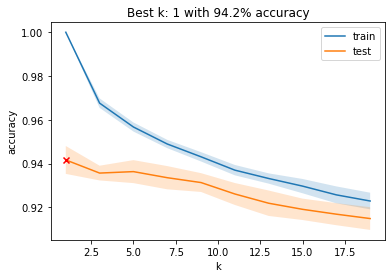

In [19]:
# Plot mean scores
plt.plot(k_values, mean_tr, label="train")
plt.plot(k_values, mean_te, label="test")

# Add marker for best score
best_k = mean_te.idxmax()
plt.scatter(best_k, mean_te.max(), marker="x", c="red", zorder=10)

# Quantify variance with ±std curves
plt.fill_between(k_values, mean_tr - std_tr, mean_tr + std_tr, alpha=0.2)
plt.fill_between(k_values, mean_te - std_te, mean_te + std_te, alpha=0.2)
plt.title("Best k: {} with {:.1f}% accuracy".format(best_k, 100 * mean_te[best_k]))
plt.ylabel("accuracy")
plt.xlabel("k")
plt.legend()
plt.show()

* The best k value has been chosen, with a total accuracy of 94.2%